## 数据读取

In [1]:
import pandas as pd

csv = '../driving_log.csv'
data = pd.read_csv(csv)

In [2]:
import cv2


def flip(image):
    return cv2.flip(image, 1)

In [3]:
STEER = 0.23
images = []
steers = []

for index in range(len(data)):
    image_center = '../' + data['center'][index].strip()
    image_center = cv2.imread(image_center)
    image_center = cv2.cvtColor(image_center, cv2.COLOR_BGR2RGB)
    steer_center = data['steering'][index]
    images.append(image_center)
    steers.append(steer_center)

    # 不等于0的时候
    if steer_center != 0:
        images.append(flip(image_center))
        steers.append(steer_center * -1.0)

        image_left = '../' + data['left'][index].strip()
        image_left = cv2.imread(image_left)
        image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB)
        steer_left = data['steering'][index] + STEER
        images.append(image_left)
        steers.append(steer_left)
        images.append(flip(image_left))
        steers.append(steer_left * -1.0)

        image_right = '../' + data['right'][index].strip()
        image_right = cv2.imread(image_right)
        image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB)
        steer_right = data['steering'][index] - STEER
        images.append(image_right)
        steers.append(steer_right)
        images.append(flip(image_right))
        steers.append(steer_right * -1.0)

In [4]:
len(images)

26411

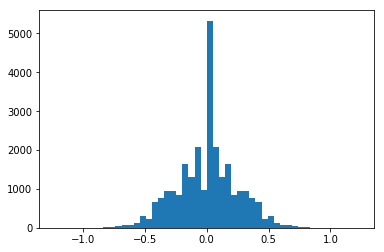

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(steers, bins=50)
plt.show()

In [6]:
images = np.array(images)
steers = np.array(steers)

In [7]:
zero_images = images[steers == 0]
zero_steers = steers[steers == 0]

keep_ratio = 0.5
keep_zeros_num = int(len(zero_images) * keep_ratio)

np.random.seed(1)
keep_ind = np.random.randint(0, len(zero_images), keep_zeros_num)

keeped_images = np.concatenate(
    [zero_images[keep_ind], images[steers != 0]], axis=0)
keeped_steers = np.concatenate(
    [zero_steers[keep_ind], steers[steers != 0]], axis=0)

In [8]:
len(keeped_images)

24230

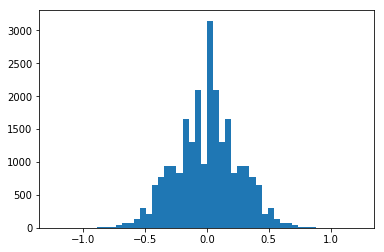

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(keeped_steers, bins=50)
plt.show()

In [10]:
images = np.array(keeped_images)
steers = np.array(keeped_steers)

## 训练

In [11]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Lambda, Cropping2D
from keras.layers import Dropout, Dense, Conv2D, AveragePooling2D, Flatten

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
def MyModel():
    # model setting
    HEIGHT = 160
    WEIGHT = 320
    CROP = ((60, 20), (0, 0))
    RESIZE = (66, 200)
    activation = 'relu'
    keep_prob = 0.5
    keep_prob_dense = 0.5

    inputs = Input(shape=(HEIGHT, WEIGHT, 3))

    # pre-processing
    x = Cropping2D(cropping=(CROP))(inputs)
    x = Lambda(lambda x: K.tf.image.resize_images(x, RESIZE))(x)
    x = Lambda(lambda x: x / 127.5 - 1.0,)(x)
#     x = Lambda(lambda x: x / 255.0 - 0.5,)(x)

    # 5x5 convolution
    x = Conv2D(24, (5, 5), strides=(2, 2), activation=activation)(x)
    x = Dropout(keep_prob)(x)

    # 5x5 convolution
    x = Conv2D(36, (5, 5), strides=(2, 2), activation=activation)(x)
    x = Dropout(keep_prob)(x)

    # 5x5 convolution
    x = Conv2D(48, (5, 5), strides=(2, 2), activation=activation)(x)
    x = Dropout(keep_prob)(x)

    # 3x3 convolution
    x = Conv2D(64, (3, 3), activation=activation)(x)
    x = Dropout(keep_prob)(x)

    # 3x3 convolution
    x = Conv2D(64, (3, 3), activation=activation)(x)
    x = Dropout(keep_prob)(x)

    # FC
    x = Flatten()(x)
    x = Dense(100, activation=activation)(x)
    x = Dropout(keep_prob_dense)(x)
    x = Dense(50, activation=activation)(x)
    x = Dropout(keep_prob_dense)(x)
    x = Dense(10, activation=activation)(x)
    x = Dropout(keep_prob_dense)(x)

    outputs = Dense(1, name='predictions')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = MyModel()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
dropout_1 (Dropout)  

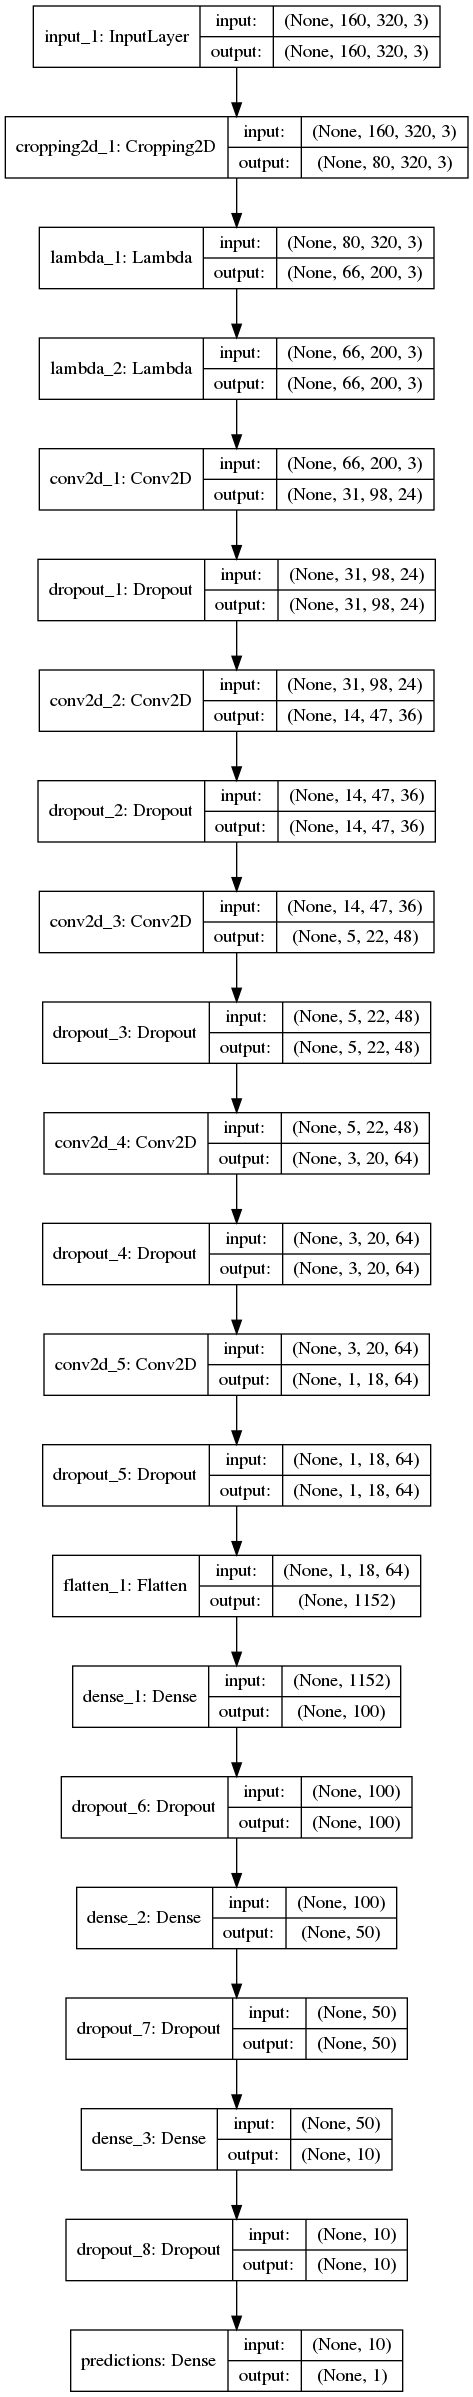

In [13]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file='model.png', show_shapes=True)
display.Image('model.png')

In [14]:
EPOCHS = 100
BATCH_SIZE = 1024
VALIDATION_SPLIT = 0.2  # 20% 验证集

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(
    'model/model.h5', save_best_only=True, save_weights_only=False)
# tensor_board = TensorBoard('log', write_graph=True, write_images=True)

model.compile(optimizer='adam', loss='mse')

In [16]:
history_object = model.fit(images, steers, epochs=EPOCHS, batch_size=BATCH_SIZE,
                           validation_split=VALIDATION_SPLIT, shuffle=True)

np.save('history_object.npy', history_object.history)

Instructions for updating:
Use tf.cast instead.
Train on 19384 samples, validate on 4846 samples
Epoch 1/100
19384/19384 [==============================] - 19s 970us/step - loss: 0.0668 - val_loss: 0.0717
Epoch 2/100
19384/19384 [==============================] - 15s 768us/step - loss: 0.0621 - val_loss: 0.0670
Epoch 3/100
19384/19384 [==============================] - 15s 765us/step - loss: 0.0544 - val_loss: 0.0597
Epoch 4/100
19384/19384 [==============================] - 15s 774us/step - loss: 0.0458 - val_loss: 0.0523
Epoch 5/100
19384/19384 [==============================] - 15s 772us/step - loss: 0.0417 - val_loss: 0.0568
Epoch 6/100
19384/19384 [==============================] - 15s 763us/step - loss: 0.0394 - val_loss: 0.0511
Epoch 7/100
19384/19384 [==============================] - 15s 767us/step - loss: 0.0381 - val_loss: 0.0502
Epoch 8/100
19384/19384 [==============================] - 15s 763us/step - loss: 0.0372 - val_loss: 0.0428
Epoch 9/100
19384/19384 [==============

19384/19384 [==============================] - 15s 786us/step - loss: 0.0279 - val_loss: 0.0335
Epoch 74/100
19384/19384 [==============================] - 15s 770us/step - loss: 0.0271 - val_loss: 0.0323
Epoch 75/100
19384/19384 [==============================] - 15s 771us/step - loss: 0.0271 - val_loss: 0.0329
Epoch 76/100
19384/19384 [==============================] - 15s 757us/step - loss: 0.0270 - val_loss: 0.0322
Epoch 77/100
19384/19384 [==============================] - 15s 774us/step - loss: 0.0274 - val_loss: 0.0330
Epoch 78/100
19384/19384 [==============================] - 15s 779us/step - loss: 0.0277 - val_loss: 0.0324
Epoch 79/100
19384/19384 [==============================] - 15s 771us/step - loss: 0.0270 - val_loss: 0.0323
Epoch 80/100
19384/19384 [==============================] - 15s 761us/step - loss: 0.0275 - val_loss: 0.0318
Epoch 81/100
19384/19384 [==============================] - 15s 775us/step - loss: 0.0274 - val_loss: 0.0347
Epoch 82/100
19384/19384 [======

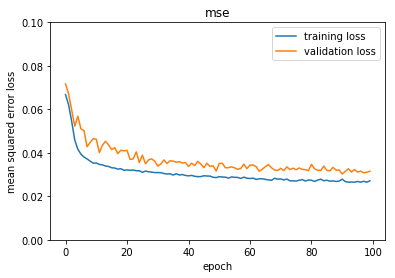

In [17]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('mse')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.ylim([0, 0.1])
plt.show()

## 测试

In [18]:
from keras.models import load_model

model = load_model('model/model.h5')

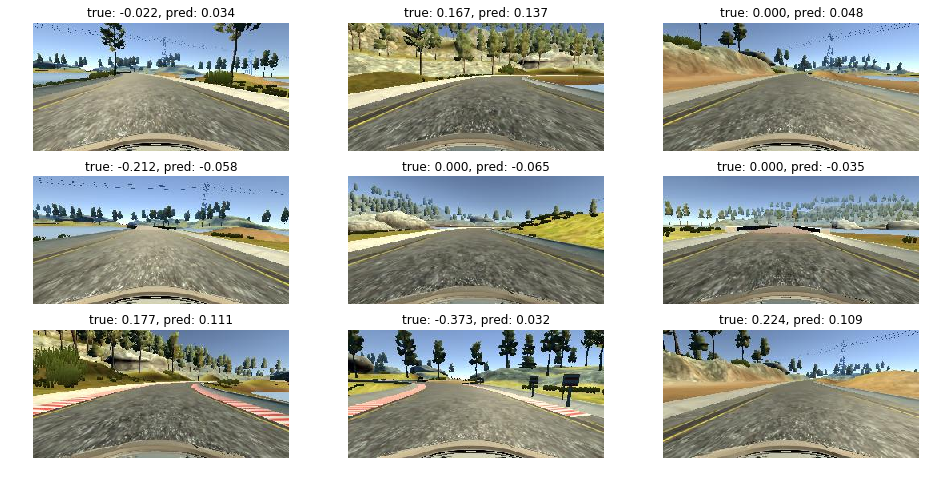

In [19]:
np.random.seed(1)

plt.figure(figsize=(16, 8))

for i in range(9):
    index = np.random.randint(0, len(data))
    image = '../' + data['center'][index].strip()
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steer = data['steering'][index]

    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = model.predict(x)

    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title('true: %.3f, pred: %.3f' % (steer, pred))
    plt.axis('off')

## 可视化

https://raghakot.github.io/keras-vis/vis.visualization/#visualize_cam

`visualize_cam(model, layer_idx, filter_indices, seed_input, penultimate_layer_idx=None, backprop_modifier=None, grad_modifier=None)`
```
model: The keras.models.Model instance. The model input shape must be: (samples, channels, image_dims...) if  image_data_format=channels_first or (samples, image_dims..., channels) if image_data_format=channels_last.

layer_idx: The layer index within model.layers whose filters needs to be visualized.

filter_indices: filter indices within the layer to be maximized. If None, all filters are visualized. (Default value = None) For  keras.layers.Dense layer, filter_idx is interpreted as the output index. If you are visualizing final  keras.layers.Dense layer, consider switching 'softmax' activation for 'linear' using utils.apply_modifications for better results.

seed_input: The input image for which activation map needs to be visualized.

penultimate_layer_idx: The pre-layer to layer_idx whose feature maps should be used to compute gradients wrt filter output. If not provided, it is set to the nearest penultimate Conv or Pooling layer.

backprop_modifier: backprop modifier to use. See backprop_modifiers. If you don't specify anything, no backprop modification is applied. (Default value = None)

grad_modifier: gradient modifier to use. See grad_modifiers. If you don't specify anything, gradients are unchanged (Default value = None)
```

In [20]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
import matplotlib.cm as cm

In [21]:
layer_idx = utils.find_layer_idx(model, 'conv2d_5')
layer_idx

12

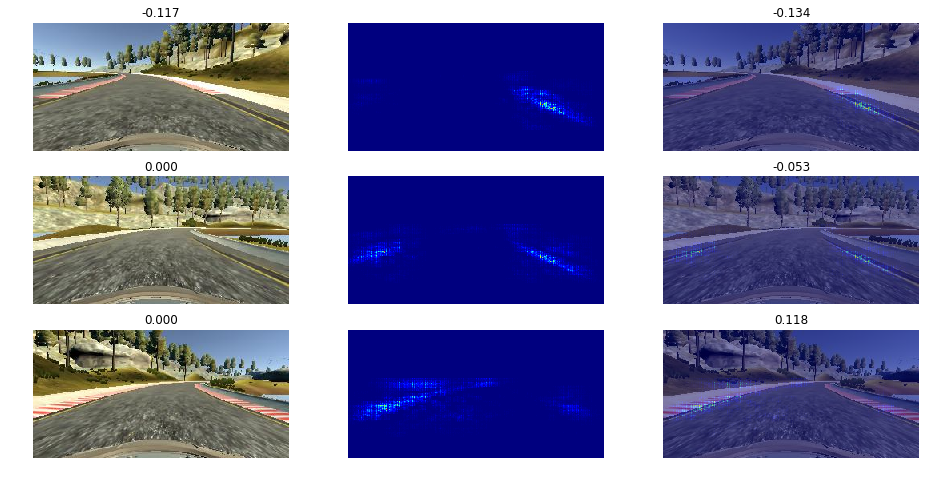

In [22]:
plt.figure(figsize=(16, 8))

for i in range(3):
    index = np.random.randint(0, len(data))
    image = '../' + data['center'][index].strip()
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steer = data['steering'][index]

    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = model.predict(x)[0][0]

    # 可视化
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=None,
                               seed_input=image, backprop_modifier='guided')
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    # 原始图
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(image, cmap='gray')
    plt.title('%.3f' % steer)
    plt.axis('off')
    # 热力图
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(jet_heatmap)
    plt.axis('off')
    # 叠加图
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(overlay(jet_heatmap, image))
    plt.title('%.3f' % pred)
    plt.axis('off')

## 生成gif

In [ ]:
import numpy as np

X_test = []
y_test = []

for index in range(len(data)):
    image = '../' + data['center'][index].strip()
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steer = data['steering'][index]

    X_test.append(image)
    y_test.append(steer)

In [ ]:
origin = []
heatmaps = []
overlays = []

for image in X_test[100:200]:
    # 预测角度
    x = np.expand_dims(image, axis=0)
    pred = int(model.predict(x)[0][0])

    # 可视化
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=None,
                               seed_input=image, backprop_modifier='guided')
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)

    origin.append(image)
    heatmaps.append(jet_heatmap)
    overlays.append(overlay(jet_heatmap, image))

In [ ]:
import imageio

# https://imageio.readthedocs.io/en/latest/userapi.html#imageio.mimread
imageio.mimsave('origin.gif', origin, duration=0.1)
imageio.mimsave('heatmap.gif', heatmaps, duration=0.1)
imageio.mimsave('overlay.gif', overlays, duration=0.1)